In [13]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, auc,accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [15]:
df = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

In [16]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [19]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [21]:
df.describe()

,Unnamed: 0,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [23]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [25]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

In [27]:
X.iloc[0]['review']

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [29]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [64]:
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download required NLTK resources
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop = set(stopwords.words('english'))  # Use a set for faster lookup
lemmatizer = WordNetLemmatizer()

# Function to preprocess reviews
def review_to_words(raw_review):
    """
    Cleans raw review text by removing HTML, non-alphabetic characters, stopwords,
    and lemmatizing the words.
    """
    # 1. Remove HTML tags
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Remove non-alphabetic characters
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. Convert to lowercase and split into words
    words = letters_only.lower().split()
    # 4. Remove stopwords
    meaningful_words = [w for w in words if w not in stop]
    # 5. Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 6. Join words into a single string
    return ' '.join(lemmatized_words)

# Apply the function to preprocess reviews
X['review_clean'] = X['review'].apply(review_to_words)

# Create feature and target variables
X_feat = X['review_clean']
y = X['condition']

X.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
C:\Users\asus\AppData\Local\Temp\ipykernel_17900\2702077937.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


,condition,review,review_clean
2,Birth Control,"I used to take another oral contraceptive, whi...",used take another oral contraceptive pill cycl...
3,Birth Control,This is my first time using any form of birth ...,first time using form birth control glad went ...
9,Birth Control,I had been on the pill for many years. When my...,pill many year doctor changed rx chateal effec...
11,Depression,"I have taken anti-depressants for years, with ...",taken anti depressant year improvement mostly ...
14,Birth Control,Started Nexplanon 2 months ago because I have ...,started nexplanon month ago minimal amount con...


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [68]:
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

In [76]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
accu_s_mnb=accuracy_score(y_test, pred)
re_s_mnb=recall_score(y_test, pred,average=None)
p_s_mnb=precision_score(y_test, pred,average=None)
f1_s_mnb=f1_score(y_test, pred,average=None)
print("accuracy:   %0.4f" % accu_s_mnb)
print("precision:", p_s_mnb)
print("recall:", re_s_mnb)
print("f1-score:", f1_s_mnb)
# cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
#plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# print(cm)

accuracy:   0.7837
precision: [0.75862978 0.98185699 1.         1.        ]
recall: [1.         0.50716648 0.02348337 0.01724138]
f1-score: [0.86275097 0.66884769 0.0458891  0.03389831]


In [82]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
accu_s_pass=accuracy_score(y_test, pred)
re_s_pass=recall_score(y_test, pred,average=None)
p_s_pass=precision_score(y_test, pred,average=None)
f1_s_pass=f1_score(y_test, pred,average=None)
print("accuracy:   %0.4f" % accu_s_pass)
print("precision:", p_s_pass)
print("recall:", re_s_pass)
print("f1-score:", f1_s_pass)
# cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# disp = ConfusionMatrixDisplay(cm, display_labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# disp = disp.plot()
# plt.xticks(rotation=90)
# plt.savefig("./images/confusion_matrix.png",bbox_inches='tight')
# plt.show()

accuracy:   0.9850
precision: [0.99342219 0.9715847  0.9566075  0.9630485 ]
recall: [0.99670024 0.98015436 0.94911937 0.8987069 ]
f1-score: [0.99505852 0.97585071 0.95284872 0.92976589]


In [84]:
dt_tf = DecisionTreeClassifier()
dt_tf.fit(tfidf_train_2,y_train)

DecisionTreeClassifier()

In [85]:
pred = dt_tf.predict(tfidf_test_2)
accu_s_dt=accuracy_score(y_test, pred)
re_s_dt=recall_score(y_test, pred,average=None)
p_s_dt=precision_score(y_test, pred,average=None)
f1_s_dt=f1_score(y_test, pred,average=None)
print("accuracy:   %0.4f" % accu_s_dt)
print("precision:", p_s_dt)
print("recall:", re_s_dt)
print("f1-score:", f1_s_dt)
# cm = confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# #ConfusionMatrixDisplay(cm, display_labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# print(cm)

accuracy:   0.9554
precision: [0.97990646 0.92384106 0.88461538 0.84841629]
recall: [0.98245919 0.92282249 0.90019569 0.80818966]
f1-score: [0.98118116 0.92333149 0.89233754 0.82781457]


In [88]:
rndf_tf = RandomForestClassifier()
rndf_tf.fit(tfidf_train_2,y_train)

RandomForestClassifier()

In [93]:
pred = rndf_tf.predict(tfidf_test_2)
accu_s_rf=accuracy_score(y_test, pred)
re_s_rf=recall_score(y_test, pred,average=None)
p_s_rf=precision_score(y_test, pred,average=None)
f1_s_rf=f1_score(y_test, pred,average=None)
print("accuracy:   %0.4f" % accu_s_rf)
print("precision:", p_s_rf)
print("recall:", re_s_rf)
print("f1-score:", f1_s_rf)
# cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# #plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# print(cm)

accuracy:   0.9582
precision: [0.96198928 0.93654267 0.98533007 0.97633136]
recall: [0.99774227 0.94377067 0.78864971 0.7112069 ]
f1-score: [0.97953964 0.94014278 0.87608696 0.82294264]


In [95]:
lgb_tf = lgb.LGBMClassifier()
lgb_tf.fit(tfidf_train_2,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.677124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382438
[LightGBM] [Info] Number of data points in the train set: 34185, number of used features: 12104
[LightGBM] [Info] Start training from score -0.394989
[LightGBM] [Info] Start training from score -1.550096
[LightGBM] [Info] Start training from score -2.817368
[LightGBM] [Info] Start training from score -2.912825


LGBMClassifier()

In [96]:
pred = lgb_tf.predict(tfidf_test_2)
accu_s_lgb=accuracy_score(y_test, pred)
re_s_lgb=recall_score(y_test, pred,average=None)
p_s_lgb=precision_score(y_test, pred,average=None)
f1_s_lgb=f1_score(y_test, pred,average=None)
print("accuracy:   %0.4f" % accu_s_lgb)
print("precision:", p_s_lgb)
print("recall:", re_s_lgb)
print("f1-score:", f1_s_lgb)
# cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# #plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
# print(cm)

accuracy:   0.9817
precision: [0.99219698 0.96103896 0.96385542 0.9516129 ]
recall: [0.99374783 0.97905182 0.93933464 0.89008621]
f1-score: [0.9929718  0.96996177 0.95143707 0.91982183]


In [99]:
result_df = pd.DataFrame({"Models":['Decision Tree','Random Forest','MultinomialNB','Passive Aggressive','LightGBM'],"Accuracy":[0.9561,
0.9568,
0.7837,
0.9848,
0.9817
]})

In [101]:
result_df

,Models,Accuracy
0,Decision Tree,0.9561
1,Random Forest,0.9568
2,MultinomialNB,0.7837
3,Passive Aggressive,0.9848
4,LightGBM,0.9817


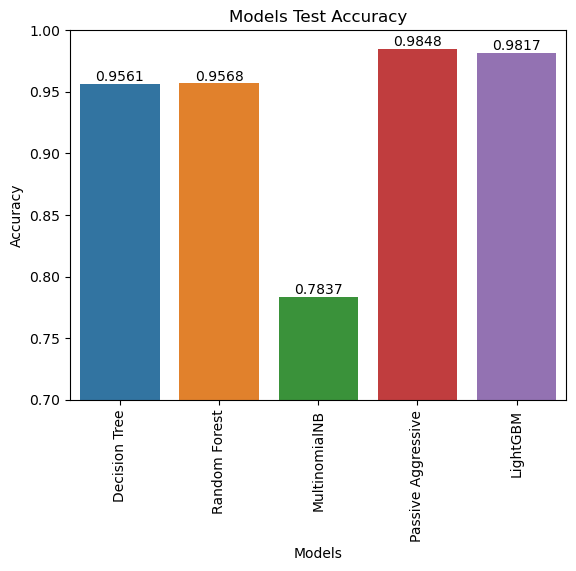

In [103]:
ax = sns.barplot(x="Models",y="Accuracy",data=result_df)
ax.bar_label(container=ax.containers[0],labels=result_df["Accuracy"])
plt.xlabel("Models")
plt.ylim(0.7,1.0)
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.title("Models Test Accuracy")
plt.savefig("./images/model accuracy.png",bbox_inches='tight')

In [105]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)

most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Birth Control')

Birth Control insertion 4.226424441151163
Birth Control cramp 4.466164134493408
Birth Control pregnant 4.824008317016336
Birth Control spotting 4.86807690631123
Birth Control bleeding 5.493556651034342
Birth Control birth control 6.139567028354932
Birth Control birth 6.318599283590748
Birth Control acne 6.7014074196423365
Birth Control pill 7.619136640063029
Birth Control period 9.982456600847812


In [107]:
## Function for Extracting Top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

# sample sentences for recommending drugs
sentences = [
  "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",]


tfidf_trigram = tfidf_vectorizer2.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Birth Control"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition: High Blood Pressure
Top 3 Suggested Drugs:
Losartan
Aldactone
Spironolactone

text: This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap. 
Condition: Depression
Top 3 Suggested Drugs:
Sertraline
Zoloft
Viibryd

text: I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losi

In [109]:
df_train[df_train['drugName']=='Sertraline'].iloc[0]

Unnamed: 0                                                 96233
drugName                                              Sertraline
condition                                             Depression
review         "1 week on Zoloft for anxiety and mood swings....
rating                                                       8.0
date                                                 May 7, 2011
usefulCount                                                    3
Name: 31, dtype: object

In [111]:
import pickle

# Save the model
with open('model.pkl', 'wb') as model_file:
    pickle.dump(pass_tf, model_file)  # Replace mnb_tf with your final model variable

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer2, vectorizer_file)